<a href="https://colab.research.google.com/github/PaoVale/FellTrack/blob/main/FeelTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Setup and Import Libraries
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download nltk duct utils
nltk.data.path.append('/usr/share/nltk_data')
nltk.download('stopwords', '/usr/share/nltk_data')
nltk.download('wordnet', '/usr/share/nltk_data')
nltk.download('punkt', '/usr/share/nltk_data')
nltk.download('punkt_tab', download_dir='/usr/share/nltk_data')
!yes | unzip -q /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Setting the style for seaborn
sns.set(style='whitegrid')

# To suppress warnings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Set verbosity during model trainig
verbose = True

# Dataset

### Dataset Loading

In [ ]:
# Load training dataset part 1
train_pt1 = pd.read_csv('Train.csv')

# Drop not used columns
train_pt1 = train_pt1.drop(columns=['Id'], axis=1)

# Load training dataset part 1
train_pt2 = pd.read_csv('Twitter_Data.csv')

# Rename columns
train_pt2 = train_pt2.rename(columns={"clean_text": "Body", "category": "Sentiment Type"})

# Replace values to match lables of part 1
train_pt2 = train_pt2.replace(-1, "negative")
train_pt2 = train_pt2.replace(0, "neutral")
train_pt2 = train_pt2.replace(1, "positive")

# Concat the two parts to get the final training set
train = pd.concat([train_pt1, train_pt2], ignore_index=True, sort=False).reset_index(drop=True)


# Load test dataset
test  = pd.read_csv('synthetic_social_media_data.csv')

In [ ]:
# Display first few rows of training set
print("Training Dataset:")
print(train.head())

In [ ]:
# Display first few rows of test set
print("\nTest Dataset:")
print(test.head())

In [ ]:
# Missing Values in Training Dataset
train.isnull().sum()

In [ ]:
# Class distribution
train['Sentiment Type'].value_counts()

## Dataset Preprocessing

In [ ]:
# Drop rows where any column has missing values
train = train.dropna()
test = test.dropna()

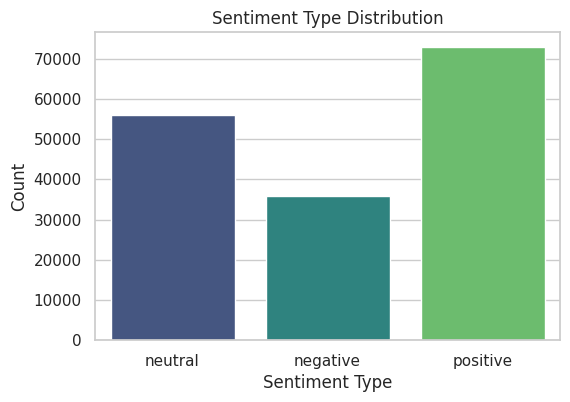

In [ ]:
# Plotting class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x='Sentiment Type', palette='viridis')
plt.title('Sentiment Type Distribution')
plt.xlabel('Sentiment Type')
plt.ylabel('Count')
plt.show()

In [ ]:
# Remove contractions
def contractions(s):
    s = re.sub(r"won't", "will not", s, flags=re.IGNORECASE)
    s = re.sub(r"wouldn't", "would not", s, flags=re.IGNORECASE)
    s = re.sub(r"couldn't", "could not", s, flags=re.IGNORECASE)
    s = re.sub(r"\’d", " would", s, flags=re.IGNORECASE)
    s = re.sub(r"can't", "can not", s, flags=re.IGNORECASE)
    s = re.sub(r"n’t", " not", s, flags=re.IGNORECASE)
    s = re.sub(r"\’re", " are", s, flags=re.IGNORECASE)
    s = re.sub(r"\’s", " is", s, flags=re.IGNORECASE)
    s = re.sub(r"\’ll", " will", s, flags=re.IGNORECASE)
    s = re.sub(r"\’t", " not", s, flags=re.IGNORECASE)
    s = re.sub(r"\’ve", " have", s, flags=re.IGNORECASE)
    s = re.sub(r"\’m", " am", s, flags=re.IGNORECASE)
    return s

# Apply the function
train['Body'] = train['Body'].apply(lambda x: contractions(x))
test['Post Content'] = test['Post Content'].apply(lambda x: contractions(x))

In [ ]:
# Remove non-alpha characters
train['Body'] = train['Body'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
test['Post Content'] = test['Post Content'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [ ]:
# Remove the extra spaces between the words
train['Body'] = train['Body'].apply(lambda x: re.sub(' +', ' ', x))
test['Post Content'] = test['Post Content'].apply(lambda x: re.sub(' +', ' ', x))

In [ ]:
# Remove the stop words by using the NLTK package
from nltk.corpus import stopwords

stop = stopwords.words('english')
train['Body'] = train['Body'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
test['Post Content'] = test['Post Content'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [ ]:
# Perform lemmatization using the wordnet lemmatizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
train['Body'] = train['Body'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
test['Post Content'] = test['Post Content'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [ ]:
# Dividi il dataset in training e test set
from sklearn.model_selection import train_test_split

X = train['Body']
y = train['Sentiment Type']

# Dividiamo i dati in training e test set (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Feature Extraction using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Init the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1, 2))

# Apply TF-IDF to vectorize the text
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nShape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)


Shape of X_train_tfidf: (131792, 6000)
Shape of X_test_tfidf: (32949, 6000)


# Models Training

### Class Weights

In [ ]:
# Compute class weight to contrast class imbalance
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {label: weight for label, weight in zip(classes, class_weight)}

print("Class Weight")
print(class_weight)

### Logistic Regression

In [ ]:
# Importing the LogisticRegression class
from sklearn.linear_model import LogisticRegression

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, class_weight=class_weight, n_jobs=-1, random_state=42, verbose=verbose)

# Fit the model on training data
logistic_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_test_pred_logistic = logistic_model.predict(X_test_tfidf)

# Logistic Regression Results
print("\n[Logistic Regression]")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_test_pred_logistic))

# Show the heatmap
sns.heatmap(confusion_matrix(y_test, y_test_pred_logistic), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()